## Data Preparation for Segmentation

###  RGB Image Augmentation

In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import shutil
from shutil import copyfile
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Reshape
from tensorflow.keras.callbacks import ModelCheckpoint

# Set paths
image_folder = r'C:\Users\BoonJane\Desktop\oralcancer\RGBimage'
mask_folder = r'C:\Users\BoonJane\Desktop\oralcancer\mask'
output_folder = r'C:\Users\BoonJane\Desktop\oralcancer\output'

In [2]:
# Create train, test, and validation directories within the output folder
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
val_folder = os.path.join(output_folder, 'val')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Get the list of class-specific folders in the image directory
class_folders = sorted(os.listdir(image_folder))

# Define augmentation parameters
augmentation_params = {
#     'rotation_range': 45,  # Rotate images by 45 degrees
    'vertical_flip': True,  # Flip images vertically
    'horizontal_flip': True  # Flip images horizontally
}

# Create an instance of ImageDataGenerator for data augmentation
data_gen = ImageDataGenerator(**augmentation_params)

# Define the number of augmented images per original image
num_augmented = 3

for class_folder in class_folders:
    # Create the corresponding class-specific folders in the train, test, and validation directories
    class_train_folder = os.path.join(train_folder, class_folder)
    class_test_folder = os.path.join(test_folder, class_folder)
    class_val_folder = os.path.join(val_folder, class_folder)

    os.makedirs(class_train_folder, exist_ok=True)
    os.makedirs(class_test_folder, exist_ok=True)
    os.makedirs(class_val_folder, exist_ok=True)

    # Get the list of image files in the current class-specific folder
    image_files = sorted(os.listdir(os.path.join(image_folder, class_folder)))

    # Split the image files into train, test, and validation sets
    train_files, test_val_files = train_test_split(image_files, test_size=0.4, random_state=42)
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    # Create the images and masks folders within each class folder
    train_images_folder = os.path.join(class_train_folder, 'images')
    train_masks_folder = os.path.join(class_train_folder, 'masks')
    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(train_masks_folder, exist_ok=True)

    test_images_folder = os.path.join(class_test_folder, 'images')
    test_masks_folder = os.path.join(class_test_folder, 'masks')
    os.makedirs(test_images_folder, exist_ok=True)
    os.makedirs(test_masks_folder, exist_ok=True)

    val_images_folder = os.path.join(class_val_folder, 'images')
    val_masks_folder = os.path.join(class_val_folder, 'masks')
    os.makedirs(val_images_folder, exist_ok=True)
    os.makedirs(val_masks_folder, exist_ok=True)

    # Move images and masks to the train folder and apply data augmentation
    for filename in train_files:
        src_image = os.path.join(image_folder, class_folder, filename)
        src_mask = os.path.join(mask_folder, class_folder, f"mask_{filename}")
        dst_image = os.path.join(train_images_folder, filename)
        dst_mask = os.path.join(train_masks_folder, f"mask_{filename}")

        # Copy the original image and mask
        shutil.copyfile(src_image, dst_image)
        shutil.copyfile(src_mask, dst_mask)

        # Apply data augmentation and save augmented images and masks
        img = load_img(dst_image, target_size=(256, 256))
        mask = load_img(dst_mask, target_size=(256, 256), color_mode='grayscale')
        
        # Convert PIL Images to NumPy arrays
        img_array = img_to_array(img)
        mask_array = img_to_array(mask)

        for i in range(num_augmented):
            # Apply data augmentation with the same seed to image and mask
            seed = np.random.randint(1, 100)
            img_aug = data_gen.random_transform(img_array, seed=seed)
            mask_aug = data_gen.random_transform(mask_array, seed=seed)
            
            # Convert augmented image and mask arrays back to images
            img_aug = array_to_img(img_aug)
            mask_aug = array_to_img(mask_aug)
            
            # Save the augmented image and mask with appropriate filenames
            img_aug_filename = f"augmented_{i+1}_{filename}"
            img_aug_path = os.path.join(train_images_folder, img_aug_filename)
            img_aug.save(img_aug_path)

            mask_aug_filename = f"augmented_mask_{i+1}_{filename}"
            mask_aug_path = os.path.join(train_masks_folder, mask_aug_filename)
            mask_aug.save(mask_aug_path)

    # Move images and masks to the test folder
    for filename in test_files:
        src_image = os.path.join(image_folder, class_folder, filename)
        src_mask = os.path.join(mask_folder, class_folder, f"mask_{filename}")
        dst_image = os.path.join(test_images_folder, filename)
        dst_mask = os.path.join(test_masks_folder, f"mask_{filename}")
        shutil.copyfile(src_image, dst_image)
        shutil.copyfile(src_mask, dst_mask)

    # Move images and masks to the validation folder
    for filename in val_files:
        src_image = os.path.join(image_folder, class_folder, filename)
        src_mask = os.path.join(mask_folder, class_folder, f"mask_{filename}")
        dst_image = os.path.join(val_images_folder, filename)
        dst_mask = os.path.join(val_masks_folder, f"mask_{filename}")
        shutil.copyfile(src_image, dst_image)
        shutil.copyfile(src_mask, dst_mask)

In [3]:
# Open an image and a mask
image_path = r"C:\Users\BoonJane\Desktop\oralcancer\output\train\Abnormal variation in nuclear shape\images\augmented_1_image_165.jpg"
mask_path = r"C:\Users\BoonJane\Desktop\oralcancer\output\train\Abnormal variation in nuclear shape\masks\augmented_mask_1_image_165.jpg"

image = Image.open(image_path)
mask = Image.open(mask_path)

# Get the size of the image and mask using the size attribute
image_size = image.size
mask_size = mask.size

print("Image size:", image_size)
print("Mask size:", mask_size)

# Convert the images to NumPy arrays
image_array = np.array(image)
mask_array = np.array(mask)

# Get the shape of the arrays using the shape attribute
image_shape = image_array.shape
mask_shape = mask_array.shape

print("Image shape:", image_shape)
print("Mask shape:", mask_shape)

Image size: (256, 256)
Mask size: (256, 256)
Image shape: (256, 256, 3)
Mask shape: (256, 256)


## UNet Segmentation Modelling

In [27]:
# Dice coefficient function
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    y_true_flat = K.reshape(y_true_flat, K.shape(y_true))
    y_pred_flat = K.reshape(y_pred_flat, K.shape(y_pred))

    intersection = K.sum(y_true_flat * y_pred_flat)
    dice = (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return dice

# Dice loss function
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# Intersection over Union (IoU) function
def iou(y_true, y_pred):
    y_true_shape = K.shape(y_true)
    y_pred_shape = K.shape(y_pred)

    if len(y_true_shape) == len(y_pred_shape):
        # Both tensors have the same number of dimensions
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    else:
        # One of the tensors has a different number of dimensions
        intersection = K.sum(K.abs(y_true * y_pred))
        union = K.sum(y_true) + K.sum(y_pred) - intersection

    iou = K.mean((intersection + 1e-15) / (union + 1e-15))
    return iou

In [5]:
# Define the U-Net model architecture
def unet(input_size):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1_pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv1_pool)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2_pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv2_pool)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3_pool = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv3_pool)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    conv4_pool = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv4_pool)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Expanding path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [28]:
model = unet(input_size=(256, 256, 3))

# edit structure of unet model
last_layer = model.layers[-1]
output_channels = last_layer.output_shape[-1]  

new_output_layer = Conv2D(3, 1, activation='sigmoid')(last_layer.output)

model = Model(inputs=model.inputs, outputs=new_output_layer)

# model compile
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coefficient, iou])

In [16]:
model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>

In [17]:
model.output

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'conv2d_49')>

In [24]:
# Set the number of epochs and batch size for training
epochs = 30
batch_size = 4

# Set the paths to the train, test, and validation data folders
train_data_dir = os.path.join(output_folder, 'train')
test_data_dir = os.path.join(output_folder, 'test')
val_data_dir = os.path.join(output_folder, 'val')

data_gen = ImageDataGenerator(rescale=1./255)

# Create the data generators for training, validation, and testing
train_data_gen = data_gen.flow_from_directory(
    train_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='input',  
    seed=42
)

val_data_gen = data_gen.flow_from_directory(
    val_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='input', 
    seed=42
)

test_data_gen = data_gen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='input', 
    seed=42
)

# Evaluate the model on the test dataset
for x, y_true in test_data_gen:
    y_pred = model.predict(x)
    break

Found 1056 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
Found 88 images belonging to 4 classes.
1/1 [==============================] - 4s 4s/step


In [25]:
# check the shapes
print("Label data shape:", y_true.shape)
print("Predicted data shape:", y_pred.shape)

# check on data because IoU value is not logical
min_value_true = np.min(y_true)
max_value_true = np.max(y_true)
min_value_pred = np.min(y_pred)
max_value_pred = np.max(y_pred)

unique_values_true = np.unique(y_true_binary)
unique_values_pred = np.unique(y_pred)

print("Unique values in y_true:", unique_values_true)
print("Unique values in y_pred:", unique_values_pred)

print("Min value of y_true:", min_value_true)
print("Max value of y_true:", max_value_true)
print("Min value of y_pred:", min_value_pred)
print("Max value of y_pred:", max_value_pred)

# # print y_true and y_predict
# print("y_true:", y_true)
# print("y_pred:", y_pred)

# check data type (need to be float)
print("Data type of y_true:", y_true.dtype)
print("Data type of y_pred:", y_pred.dtype)

Label data shape: (4, 256, 256, 3)
Predicted data shape: (4, 256, 256, 3)
Unique values in y_true: [0 1]
Unique values in y_pred: [0.36158746 0.3616156  0.36164823 ... 0.6375838  0.6376162  0.6376443 ]
Min value of y_true: 0.0
Max value of y_true: 1.0
Min value of y_pred: 0.36158746
Max value of y_pred: 0.6376443
Data type of y_true: float32
Data type of y_pred: float32


In [29]:
checkpoint_path = "unetrgb_weights.h5"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss', 
    verbose=1,  
    save_best_only=True,  
    save_weights_only=True  
)

# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen),
    callbacks=[checkpoint],
)

Epoch 1/30
264/264 [==============================] - ETA: 0s - loss: 0.5581 - dice_coefficient: 0.4419 - iou: 0.2711
Epoch 1: val_loss improved from inf to 0.50819, saving model to unetrgb_weights.h5
264/264 [==============================] - 2319s 9s/step - loss: 0.5581 - dice_coefficient: 0.4419 - iou: 0.2711 - val_loss: 0.5082 - val_dice_coefficient: 0.4918 - val_iou: 0.3122
Epoch 2/30
264/264 [==============================] - ETA: 0s - loss: 0.5142 - dice_coefficient: 0.4858 - iou: 0.3059
Epoch 2: val_loss improved from 0.50819 to 0.48180, saving model to unetrgb_weights.h5
264/264 [==============================] - 2312s 9s/step - loss: 0.5142 - dice_coefficient: 0.4858 - iou: 0.3059 - val_loss: 0.4818 - val_dice_coefficient: 0.5182 - val_iou: 0.3392
Epoch 3/30
264/264 [==============================] - ETA: 0s - loss: 0.4846 - dice_coefficient: 0.5154 - iou: 0.3302
Epoch 3: val_loss improved from 0.48180 to 0.45276, saving model to unetrgb_weights.h5
264/264 [==================

In [30]:
# Evaluate the model on the validation dataset
validation_loss, validation_dice_coefficient, validation_iou = model.evaluate(val_data_gen, steps=len(val_data_gen))
print("Validation Loss:", validation_loss)
print("Validation Dice Coefficient:", validation_dice_coefficient)
print("Validation IoU:", validation_iou)

22/22 [==============================] - 62s 3s/step - loss: 0.2170 - dice_coefficient: 0.7830 - iou: 0.7064
Validation Loss: 0.21700286865234375
Validation Dice Coefficient: 0.7829971313476562
Validation IoU: 0.706390917301178


In [31]:
# Test the model on the test dataset
test_loss, test_dice_coefficient, test_iou = model.evaluate(test_data_gen, steps=len(test_data_gen))
print("Test Loss:", test_loss)
print("Test Dice Coefficient:", test_dice_coefficient)
print("Test IoU:", test_iou)

22/22 [==============================] - 62s 3s/step - loss: 0.2206 - dice_coefficient: 0.7794 - iou: 0.6977
Test Loss: 0.22058573365211487
Test Dice Coefficient: 0.7794142365455627
Test IoU: 0.6976647973060608


In [32]:
# Use the model for predictions
predictions = model.predict(test_data_gen)
# 'predictions' is an array containing the predicted masks for the test images

# Save the predicted masks as images
output_folder = r"C:\Users\BoonJane\Desktop\oralcancer\unet\predictions"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i, (x, _) in enumerate(test_data_gen):
    # Generate predictions for batch of images
    y_pred = model.predict(x)

    # Save each predicted mask as an image
    for j in range(len(y_pred)):
        mask = y_pred[j] > 0.5  # Threshold predicted mask
        mask_img = array_to_img(mask)
        mask_img.save(os.path.join(output_folder, f"prediction_{i * batch_size + j}.jpg"))

    if i == len(test_data_gen) - 1:
        # Processed all test data
        break

1/1 [==============================] - 2s 2s/step


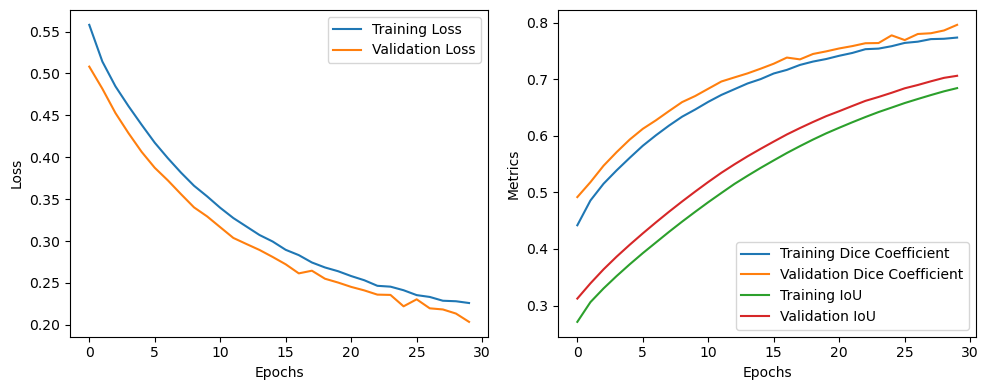

In [33]:
# Plot loss and metrics curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# save model weight
model.save('unetrgb.h5')